# Organize Variables
_Examine and modify datatypes - categorical, continuous, discrete. Organize dataset._ 

Polygons has most of the data and will serve as the focus of this EDA.

## Remove Non-Glacier Columns
Since the purpose is to find data stories about glaciers rather than the glacier research process, variables pertaining data submission and measurement uncertainty are identified, referencing the [User Guide](https://nsidc.org/sites/default/files/nsidc-0272-v001-userguide_1.pdf) and the [GLIMS Description of fields](http://www.glims.org/MapsAndDocs/downloaded_field_desc.html), verified, and removed.

In [1]:
# Import libraries
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

# Check working directory
current_directory = os.getcwd()
print("Current Directory:", current_directory)

# Ask pandas to display all columns
pd.set_option('display.max_columns', None)

Current Directory: /Users/yun/Documents/GLIMS/glims_notebooks


In [2]:
# Load Esri shapefiles as geopandas dataframes
polygons = gpd.read_file("GLIMS_20230716/glims_download_13173/glims_polygons.shp")

In [3]:
polygons.dtypes

line_type       object
anlys_id       float64
glac_id         object
anlys_time      object
area           float64
db_area        float64
width          float64
length         float64
primeclass     float64
min_elev       float64
mean_elev      float64
max_elev       float64
src_date        object
rec_status      object
glac_name       object
wgms_id         object
local_id        object
glac_stat       object
subm_id        float64
release_dt      object
proc_desc       object
rc_id          float64
geog_area       object
chief_affl      object
loc_unc_x        int64
loc_unc_y        int64
glob_unc_x       int64
glob_unc_y       int64
submitters      object
analysts        object
geometry      geometry
dtype: object

In [4]:
# all are "okay", as expected from documentation
polygons.rec_status.value_counts()
polygons.proc_desc.nunique()

165

In [5]:
# Lots of "None"
polygons.wgms_id.value_counts(normalize=True) # 91% "None"
polygons.local_id.value_counts(normalize=True) # 65% "None"

None                        0.649243
GR50.11096E32.29309N_Zr2    0.000173
GIJR115                     0.000133
NPI-22                      0.000115
NPI-39                      0.000115
                              ...   
08EC232531E55523N           0.000002
08AC223282E59430N           0.000002
08EA232117E57081N           0.000002
08MG236598E50776N           0.000002
3266                        0.000002
Name: local_id, Length: 69166, dtype: float64

In [6]:
# Some of these fields may be related to each other: proc_desc and analysts; submitters, rc_id, geog_area, and chief_affl
polygons[[
    #'line_type', #'rec_status', #'glac_stat', 
    #'area', 'db_area','width', 'length', 'primeclass', 'min_elev', 'mean_elev', 'max_elev',
    'anlys_id', 'glac_id', 'glac_name', 'wgms_id', 'local_id',
    'anlys_time', 'src_date', 'subm_id', 'release_dt', 
    'proc_desc', 'rc_id', 'geog_area','chief_affl', 'submitters', 'analysts', 
    #'loc_unc_x', 'loc_unc_y', 'glob_unc_x', 'glob_unc_y', #'geometry'
]].nunique().sort_values(ascending=False)

anlys_id      557884
glac_id       328115
local_id       69166
glac_name      35112
wgms_id        17239
src_date        1178
subm_id          624
anlys_time       456
release_dt       278
proc_desc        165
analysts         109
submitters        67
rc_id             53
geog_area         49
chief_affl        46
dtype: int64

In [7]:
# Alignments with higher value counts
polygons[[
    'proc_desc', 
    'rc_id', 
    'geog_area', # 'umbrella' and 'various' categories too large to be useful
    'chief_affl', 
    'submitters', 
    'analysts'
]].value_counts()

proc_desc                                                                                                                                                                                                                                                       rc_id  geog_area                                                               chief_affl                                                         submitters                        analysts                                                                                                                                         
Semi-automated glacier classification; Semi-automated mapping from optical imagery, with manual editing.                                                                                                                                                        36.0   Asia                                                                    Nagoya University                                                  Sakai, Akiko    

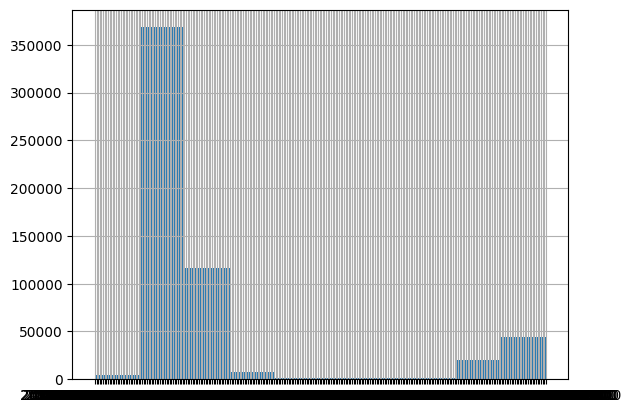

In [8]:
# Continuous Temporal, not defined in documentation, data release?
polygons.release_dt.hist();

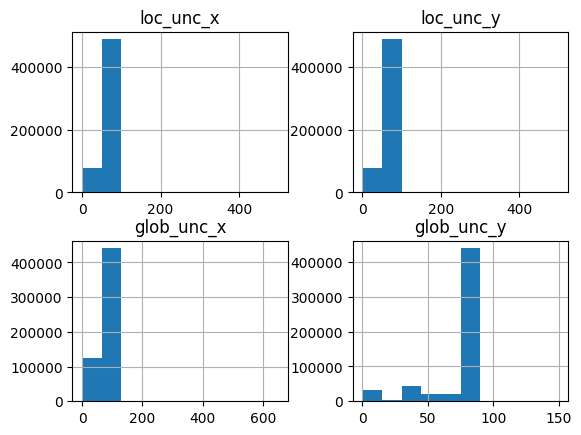

In [9]:
# Positional Uncertainty, Discrete
polygons[['loc_unc_x', 'loc_unc_y', 'glob_unc_x', 'glob_unc_y']].hist();

In [10]:
# Remove submission-related columns
polygons1 = polygons.drop(labels=[
    'rec_status', 'wgms_id', 'local_id', 
    'subm_id', 'release_dt', 'proc_desc', 
    'rc_id', 'geog_area', 'chief_affl', 
    'loc_unc_x', 'loc_unc_y', 'glob_unc_x', 'glob_unc_y',
    'submitters', 'analysts'
], axis=1)

In [11]:
polygons1.dtypes

line_type       object
anlys_id       float64
glac_id         object
anlys_time      object
area           float64
db_area        float64
width          float64
length         float64
primeclass     float64
min_elev       float64
mean_elev      float64
max_elev       float64
src_date        object
glac_name       object
glac_stat       object
geometry      geometry
dtype: object

## Remove Non-Glacier Rows
Remove polygon features representing non-glacier boundaries.

In [12]:
# Most entities are glacier boundaries.
polygons1.line_type.value_counts()

glac_bound     564112
debris_cov       1005
intrnl_rock       452
pro_lake          291
supra_lake         18
basin_bound         9
Name: line_type, dtype: int64

In [13]:
# Remove non-glacier entities.
polygons2 = polygons1[polygons1.line_type=="glac_bound"]
#polygons2.line_type.value_counts()
polygons2.drop('line_type', axis=1, inplace=True)

/var/folders/13/hf_sfnls1lq6kn8vsc92q40h0000gn/T/ipykernel_36738/1093122923.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  polygons2.drop('line_type', axis=1, inplace=True)


In [14]:
polygons2.dtypes

anlys_id       float64
glac_id         object
anlys_time      object
area           float64
db_area        float64
width          float64
length         float64
primeclass     float64
min_elev       float64
mean_elev      float64
max_elev       float64
src_date        object
glac_name       object
glac_stat       object
geometry      geometry
dtype: object

In [15]:
# Minimal NAN's address later
polygons2.isna().sum()

anlys_id       0
glac_id        0
anlys_time     0
area           0
db_area        0
width          0
length         0
primeclass     0
min_elev       0
mean_elev      0
max_elev       0
src_date       0
glac_name     12
glac_stat      0
geometry       0
dtype: int64

In [16]:
polygons2.sample(5)

,anlys_id,glac_id,anlys_time,area,db_area,width,length,primeclass,min_elev,mean_elev,max_elev,src_date,glac_name,glac_stat,geometry
564072,715697.0,G272254E81788N,2021-08-01T00:00:00,13.111200,13.178300,0.0,0.0,0.0,279.0,611.0,896.0,1999-07-24T00:00:00,None,exists,"POLYGON Z ((-87.62692 81.80468 0.00000, -87.62..."
402885,638342.0,G091054E47736N,2018-07-01T00:00:00,0.000000,0.068239,0.0,0.0,0.0,0.0,0.0,0.0,2002-07-10T00:00:00,None,exists,"POLYGON Z ((91.05266 47.73642 0.00000, 91.0526..."
382344,522870.0,G018607E78547N,2017-10-01T00:00:00,0.000000,36.640700,0.0,0.0,0.0,0.0,0.0,0.0,1990-07-31T00:00:00,Johansenbreen,exists,"POLYGON Z ((18.87952 78.52250 0.00000, 18.8334..."
422908,609777.0,G081162E35762N,2018-07-01T00:00:00,0.000000,0.832443,0.0,0.0,0.0,0.0,0.0,0.0,1996-09-12T00:00:00,CN5Y641E0005,exists,"POLYGON Z ((81.16366 35.75648 0.00000, 81.1637..."
200718,253539.0,G079641E36027N,2014-06-15T00:00:00,0.036378,0.036391,0.0,0.0,0.0,5641.0,5752.0,5823.0,2009-09-07T00:00:00,CN5Y641K0280,exists,"POLYGON Z ((79.63911 36.02617 0.00000, 79.6391..."


In [17]:
#polygons2.to_csv("GLIMS_20230716/polygons2.csv", index=False)

OSError: [Errno 28] No space left on device